# Import useful functions

In [2]:
#given a dataset for H(z), z, err(H), we do an MCMC analysis and find corner plots for the data

import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from IPython.display import display, Math
import pandas as pd

# Background equations

In [3]:
#------ BACKGROUND EQUATIONS ------

# Equation 2.14
def Omega_Lambda(cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    
    return 1 - Omega_m - Omega_r - Omega_k + alpha_tilde * (1 - C_t**2 + Omega_k**2 - 2*Omega_k)

# Equation 2.13
def X(z, cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z)** 4 + Omega_lambda)

# Equation 2.12
def E(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    if alpha_tilde == 0:
        ans = np.sqrt(Omega_m * (1 + z) ** 3 + Omega_r * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)
    else:
        ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2 * alpha_tilde * Omega_k * (1+z) ** 2))/(2 * alpha_tilde))
    
    return ans

# Equations to test specific set of parameters

In [4]:
# --- CMB ----

# etc

# Data

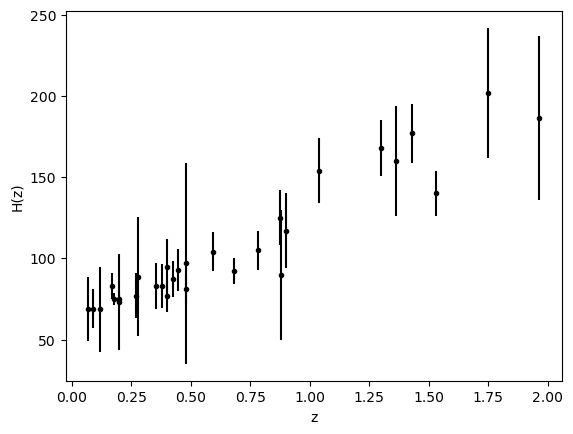

In [5]:
#import data Cosmic chronometers
df = pd.read_excel (r'~/Desktop/Newcastle/4DEGB/4DEGB_programs/H_z_cosmic_chronometers.xlsx')

# Plot our data
x_CC = np.array(df.z)
yerr_CC = np.diag(df.Err)
y_CC = np.array(df.H_z)


plt.errorbar(x_CC, y_CC, yerr=np.array(np.diag(yerr_CC)), fmt=".k", capsize=0)
plt.xlabel("z")
plt.ylabel("H(z)");

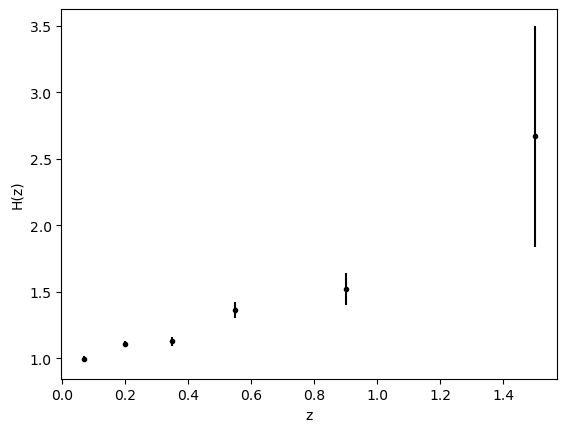

In [6]:
# Get data from SNe

x_SNe = np.array([0.07,0.2,0.35,0.55,0.9,1.5])

# find the correct errors from paper
corr_SNe =np.array([[1,0.39,0.53,0.37,0.01,-0.02],
                 [0.39,1,-0.14,0.37,0.01,-0.02],
                 [0.53,-0.14,1,-0.16,0.17,-0.07],
                 [0.37,0.37,-0.16,1,-0.39,0.15],
                 [0.01,-0.08,0.17,-0.39,1,-0.19],
                 [-0.02,-0.08,-0.07,0.15,-0.19,1]])
err_SNe = np.array([0.023,0.02,0.037,0.063,0.12,0.83])
yerr_SNe = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        yerr_SNe[i][j] = corr_SNe[i][j]*err_SNe[i]*err_SNe[j]

y_SNe = np.array([0.997,1.111,1.128,1.364,1.52,2.67])

# Plot our data

plt.errorbar(x_SNe, y_SNe, yerr=np.array(np.sqrt(np.diag(yerr_SNe))), fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.xlabel("z")
plt.ylabel("H(z)");

In [7]:
# Combined data

x = [x_CC,x_SNe]
y = [y_CC, y_SNe]
yerr = [yerr_CC,yerr_SNe]

# Likelihood for cosmic chronometers, "CC"

In [8]:
def log_likelihood_CC(theta, z, y, yerr):
    alpha_t, C_t, Omg_m = theta 
    H0 = 67
    Omg_r = (2.47e-5*(H0/100)**-2)*1.6949484 # last factor due to neutrinos
    model = np.array(H0 * E(z, [Omg_m , 0 , 0 , Omg_r , alpha_t, C_t])) #  Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t
    #sigma2 = np.array(yerr)**2
    return -0.5 * np.matmul(np.matmul((y-model),np.linalg.inv(np.matmul(yerr,yerr))),np.transpose(y-model))

In [9]:
def log_probability_CC(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_CC(theta, x, y, yerr)

# Likelihood for SNe data "SNe"

In [10]:
def log_likelihood_SNe(theta, z, y, yerr):
    alpha_t,C_t, Omg_m = theta 
    H0 = 67
    Omg_r = (2.47e-5*(H0/100)**-2)*1.6949484 # last factor due to neutrinos
    model = np.array(E(z, [Omg_m , 0 , 0 , Omg_r , alpha_t, C_t]))
    return -0.5 * np.matmul(np.matmul((y-model),np.linalg.inv(yerr)),np.transpose(y-model))

In [11]:
def log_probability_SNe(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_SNe(theta, x, y, yerr)

# Combined MCMC analysis

In [12]:
def log_prior(theta):
    alpha_t, C_t, Omg_m = theta
    if 0 < alpha_t < 1 and 0 < C_t < 1 and 0 < Omg_m < 1:
        return 0.0
    return -np.inf

In [13]:
def log_probability(theta, x, y, yerr):
    x_CC,x_SNe = x
    y_CC, y_SNe = y
    yerr_CC,yerr_SNe = yerr
    log_prob = log_probability_CC(theta, x_CC, y_CC, yerr_CC) \
             + log_probability_SNe(theta, x_SNe, y_SNe, yerr_SNe)
    return log_prob

In [14]:
#MCMC method

# Choose the estimated parameters.
alpha_t_est = 0.5
C_t_est = 0.5
Omg_m_est = 0.5

# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
#and then run 10,000 steps of MCMC
pos = [alpha_t_est , C_t_est , Omg_m_est] + 1e-2 * np.random.randn(50, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 10000, progress=True);

100%|████████████████████████████████████| 10000/10000 [01:24<00:00, 118.38it/s]


(30000, 3)


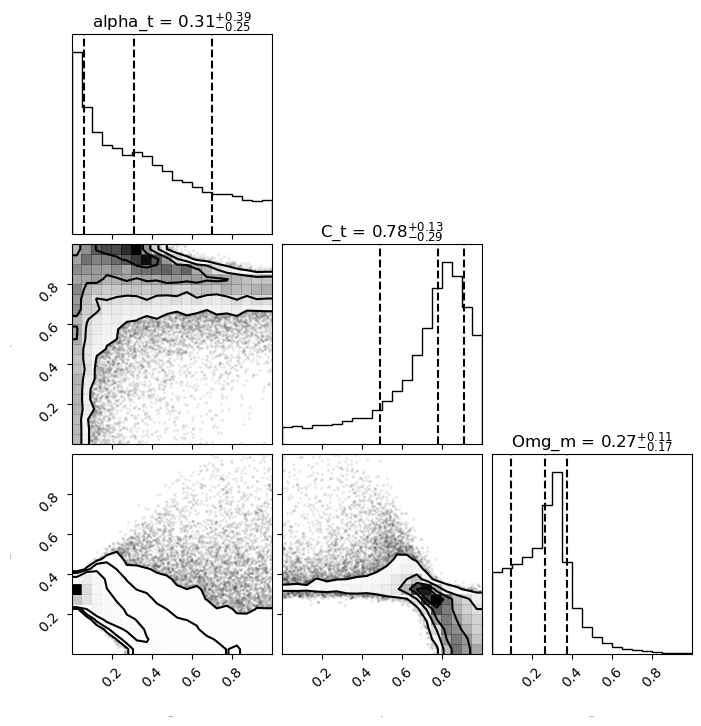

In [15]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
labels = ["alpha_t","C_t", "Omg_m"]
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels, show_titles=True, quantiles=[0.16, 0.50, 0.84],
                    label_kwargs={'labelpad':20, 'fontsize':0}, fontsize=8
);


50
10000
3
10000


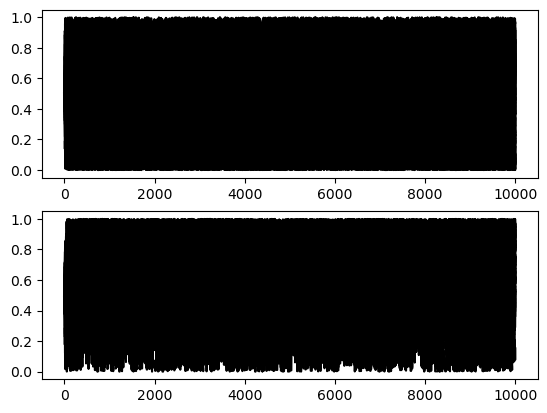

In [16]:
samples_chain = sampler.chain
print(len(samples_chain))
print(len(samples_chain[0]))
print(len(samples_chain[0][0]))
print(len(samples_chain[0, :, 0]))

fig, ax = plt.subplots(2)

for i in range(len(samples_chain)):
    ax[0].plot(samples_chain[i, :, 0], color = "black")
    ax[1].plot(samples_chain[i, :, 1], color = "black")


In [17]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

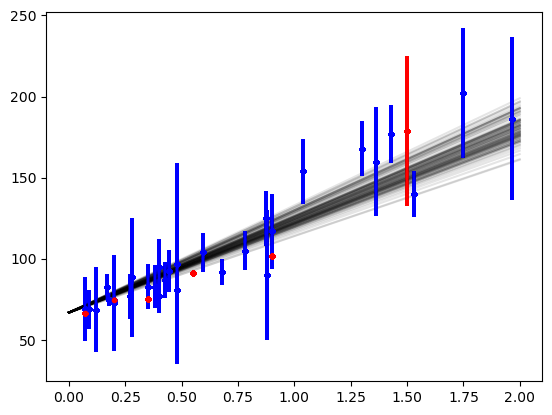

In [18]:
# --- PLOT DATA WITH ESTIMATED PARAMS -----

xl = np.array([0, 2])

# cosmic chronometers
for alpha_t, C_t, Omg_m in flat_samples[np.random.randint(len(flat_samples), size=100)]:
    H0 = 67
    Omg_r = 2.47e-5*(H0/100)**-2
    plt.plot(xl, H0*E(xl, [Omg_m , 0 , 0 , Omg_r , alpha_t,C_t]), color="k", alpha=0.1)
    plt.errorbar(x_CC, y_CC, yerr=np.array(np.diag(yerr_CC)), fmt=".b")
    plt.errorbar(x_SNe, H0*y_SNe, yerr=np.array(np.diag(yerr_SNe))*H0, fmt=".r")
    